In [1]:
# !pip install h3
# !conda install -c conda-forge h3-py
# !pip install --upgrade shapely
# !pip install osmnx --upgrade

In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import h3
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [ ]:

start_time = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  # Remove .gz
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

os.remove(file_name)  # Optional: clean up compressed file

df = pd.read_csv(csv_name)

#Save for use later
df.to_csv('../data/raw/df_sr_hex.csv', index=False)

print(f"Loaded {file_name} in {time.time() - start_time:.2f} seconds")

Processing sr_hex.csv.gz...


✅ Loaded sr_hex.csv.gz in 18.91 seconds


#### A Quick Look at the Data

In [4]:
df.head().T

,0,1,2,3,4
notification_number,400583534,400555043,400589145,400538915,400568554
reference_number,9109491785.0,9108995239.0,9109614461.0,9108601346.0,NaN
creation_timestamp,2020-10-07 06:55:18+02:00,2020-07-09 16:08:13+02:00,2020-10-27 10:21:59+02:00,2020-03-19 06:36:06+02:00,2020-08-25 09:48:42+02:00
completion_timestamp,2020-10-08 15:36:35+02:00,2020-07-14 14:27:01+02:00,2020-10-28 17:48:15+02:00,2021-03-29 20:34:19+02:00,2020-08-31 08:41:13+02:00
directorate,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY
department,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management
branch,RIM Area Central,RIM Area East,RIM Area East,RIM Area North,RIM Area South
section,District: Blaauwberg,District : Somerset West,District : Somerset West,District : Bellville,District : Athlone
code_group,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups
code,Pothole&Defect Road Foot Bic Way/Kerbs,Manhole Cover/Gully Grid,Manhole Cover/Gully Grid,Paint Markings Lines&Signs,Pothole&Defect Road Foot Bic Way/Kerbs


### Get an Overview of the data

In [5]:
print("Dataset Info:")
df.info()
print("\nMissing values:")
print(df.isna().mean().sort_values(ascending=False))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            129669 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null 

- many features have missing values not sure if it actually matters
- according to the documentation, missing h3_level8_index values were set to '0'
- there are 22.5% latitude and longitudes that are missing - this means that there are also 22.5% h3_level8_index missing. Quite high but will have to drop these rows as without h3_level8_index the rows are of no value.
- cause_code and cause_code_group both have 86% missing values - won't use these features
- code and code_group have zero missing values.  Let's see the values in these features...





In [14]:

print(f"There are {df.code.nunique()} unique codes and {df.code_group.nunique()} unique code_group values)")
print("\nTop code values:")
print(df['code'].value_counts().head(10))
print("\nTop code_group values:")
print(df['code_group'].value_counts().head(10))
print("\nTop Departments:")
print(df['department'].value_counts().head(10))
print("\nDate Range:")
df['creation_timestamp'] = pd.to_datetime(df['creation_timestamp'])
print(df['creation_timestamp'].min(), "to", df['creation_timestamp'].max())

There are 452 unique codes and 38 unique code_group values)

Top code values:
code
Sewer: Blocked/Overflow             130368
No Power                             77809
No Water WMD                         48021
Customer : Reconnection Request      22316
Street Lights - Single Light Out     21583
Broken Leading                       17990
Street Lights - All Lights Out       17202
Stolen Bins - 240L                   16156
Damaged Bin - 240L                   15339
Leak at Water Meter / Stopcock       15137
Name: count, dtype: int64

Top code_group values:
code_group
ELECTRICITY TECHNICAL COMPLAINTS           157577
SEWER                                      143948
WATER                                       96472
WATER MANAGEMENT DEVICE                     71028
SOLID WASTE                                 65626
WATER AND SANITATION OR METER QUERIES       56740
REVENUE                                     36356
ELECTRICITY FINANCIAL AND METER READING     16684
HOUSING - EXISTING        

In [15]:
# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(729270, 16)
(729270, 16)


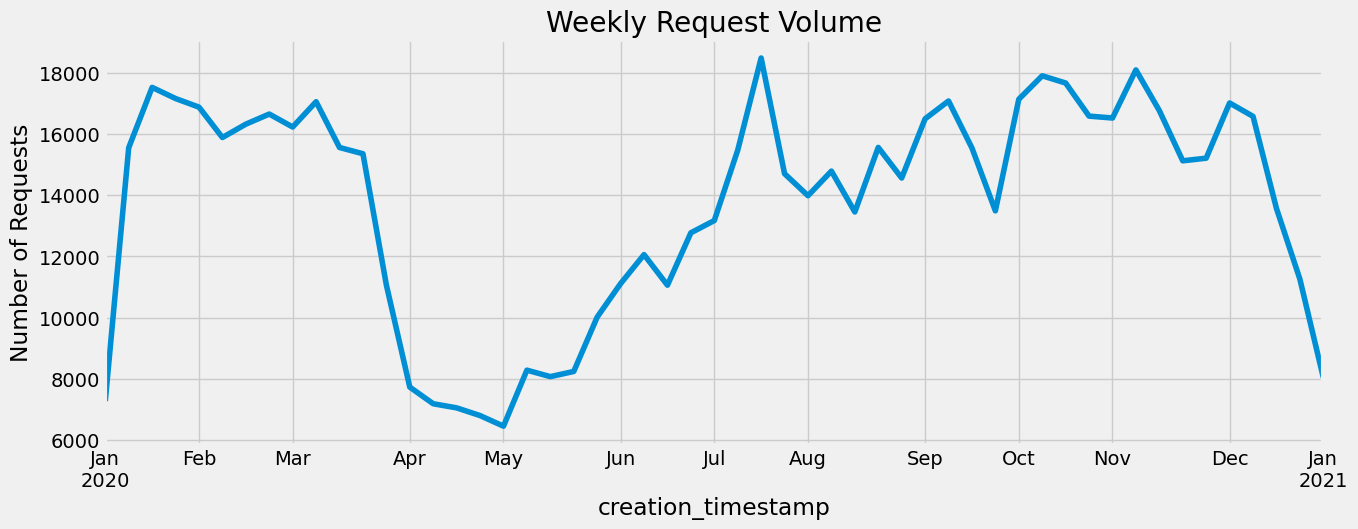

In [16]:
# Plot the data
plt.figure(figsize=(14,5))
df.set_index('creation_timestamp').resample('W').size().plot()
plt.title("Weekly Request Volume")
plt.ylabel("Number of Requests")
plt.show()

- steep drop during Covid lockdown and Christmas,  Steep increase in early January.  Spike in middle of July (?) 

<Axes: >

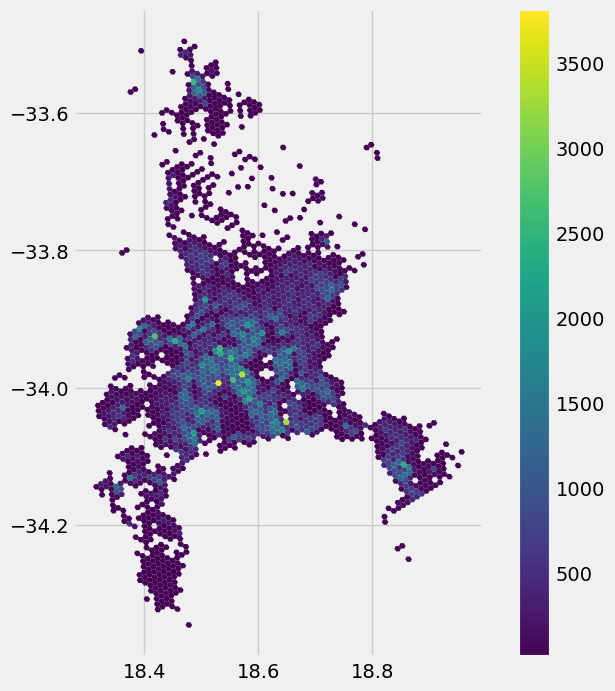

In [19]:
# Hexbin plot / geospatial hexbin heatmap

def h3_to_geo_boundary(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

def create_hex_gdf(df, h3_col='h3_level8_index'):
    df = df[df[h3_col].notna()].drop_duplicates(subset=[h3_col]).copy()
    df['geometry'] = df[h3_col].apply(h3_to_geo_boundary)
    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Plot H3 cells with request count
gdf = create_hex_gdf(df)
gdf = gdf.merge(df.groupby('h3_level8_index').size().reset_index(name='request_count'), on='h3_level8_index')  # Total number of requests per hex for the entire dataset period
gdf.plot(column='request_count', cmap='viridis', legend=True, figsize = (8,8))

In [35]:
# Investigate hex's with highest requests

top_hexes = gdf.sort_values('request_count', ascending=False).head(5)
print(top_hexes[['h3_level8_index', 'request_count']])

hex_id = top_hexes.iloc[0]['h3_level8_index']
df_top = df[df['h3_level8_index'] == hex_id]

# department, request_type: are they all from one department?

print("\nTop Request Groups:")
print(df_top['code_group'].value_counts().head())
print("\nTop Request Types:")
print(df_top['code'].value_counts().head())
print("\nTop Departments:")
print(df_top['department'].value_counts().head())

      h3_level8_index  request_count
285   88ad3612a9fffff           3815
620   88ad361009fffff           3464
1307  88ad368985fffff           3393
8     88ad361519fffff           2797
185   88ad361051fffff           2650

Top Request Groups:
code_group
HOUSING - EXISTING                  1733
ELECTRICITY TECHNICAL COMPLAINTS     717
SEWER                                583
WATER MANAGEMENT DEVICE              207
WATER                                202
Name: count, dtype: int64

Top Request Types:
code
Plumbing                   757
Sewer: Blocked/Overflow    555
Carpentry                  532
No Power                   466
Electrical                 294
Name: count, dtype: int64

Top Departments:
department
Home Ownership Transfer, Tenancy Management and Staff Housing    1713
Electricity Generation and Distribution                           789
Distribution Services                                             775
Commercial Services                                               355


In [36]:
# Request Type by Suburb
request_by_suburb = df.groupby(['official_suburb', 'code']).size().unstack(fill_value=0)
request_by_suburb.head().T

official_suburb,AAN DE WIJNLANDEN ESTATE,ACACIA PARK,ADMIRALS PARK,ADRIAANSE,AIRPORT
code,,,,,
AWS: Enquiry,0,0,0,0,0
AWS: Existing Installation,0,0,0,0,0
Abandoned Vehicles,0,0,1,0,0
Accident Damaged,0,0,0,0,0
Account Enquiries - Contact Centres only,0,0,0,0,0
...,...,...,...,...,...
Water Trough Defective,0,0,0,0,0
Water Trough Request,0,0,0,0,0
Water Turn on Supply Requested,0,0,0,0,0


<Axes: title={'center': 'Top Suburbs by Sewer: Blocked/Overflow Requests'}, ylabel='official_suburb'>

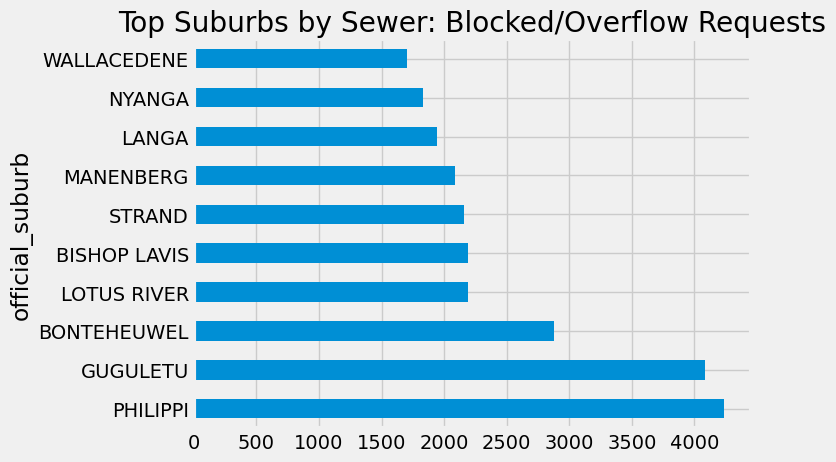

In [37]:
#Top 10 suburbs for request type Sewer: Blocked/Overflow

request_by_suburb['Sewer: Blocked/Overflow'].sort_values(ascending=False).head(10).plot(kind='barh', title='Top Suburbs by Sewer: Blocked/Overflow Requests')

<Axes: title={'center': 'Top Suburbs by No Power'}, ylabel='official_suburb'>

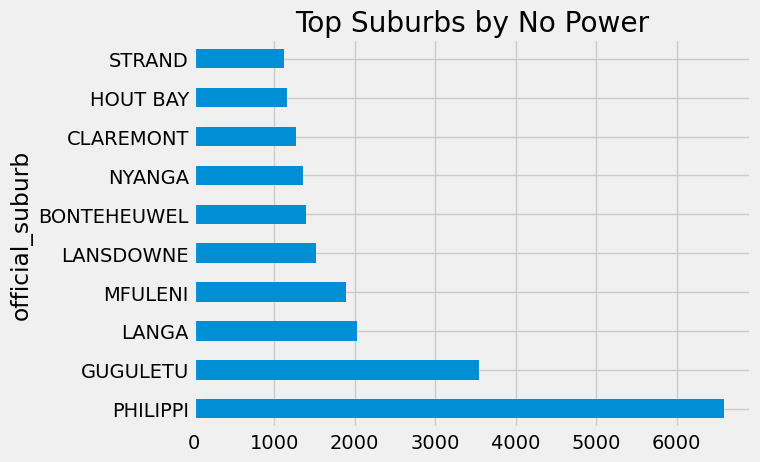

In [38]:
#Top 10 suburbs for request type No Power

request_by_suburb['No Power'].sort_values(ascending=False).head(10).plot(kind='barh', title='Top Suburbs by No Power')

<Axes: title={'center': 'Request Types in MOWBRAY'}, xlabel='code'>

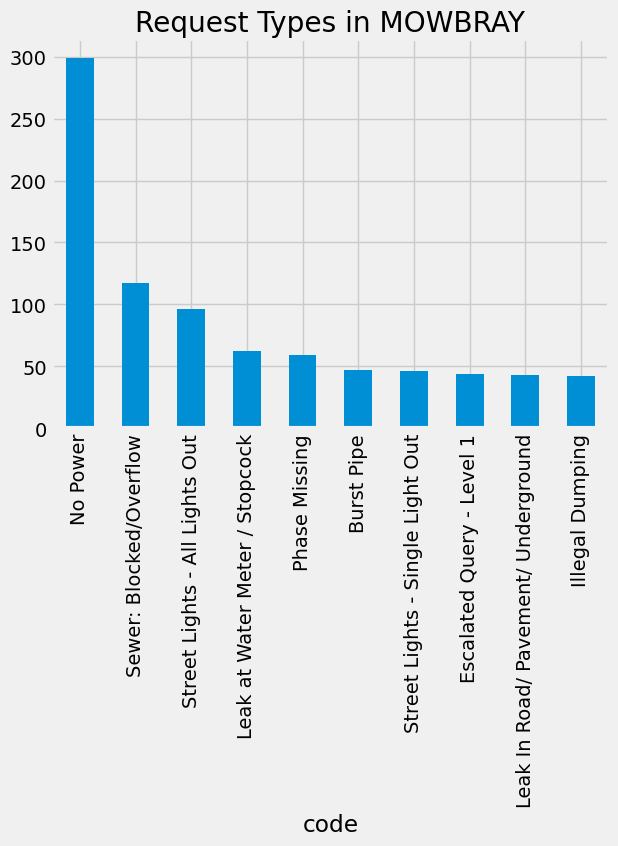

In [39]:
# Single request by suburb
request_by_suburb.loc['MOWBRAY'].sort_values(ascending=False).head(10).plot(kind='bar', title='Request Types in MOWBRAY')